In [12]:
import numpy as np
import pandas as pd
import pyarrow

from pandas_profiling import ProfileReport

from ipyleaflet import * 
from ipyleaflet import (
    Map, TileLayer, SplitMapControl, Marker, basemaps, MarkerCluster, Choropleth
)

import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt




In [38]:
df = pd.read_parquet('./data/safety-SanFrancisco.parquet') 
df = df.drop(['dataType', 'extendedProperties'], axis=1)
for col in ["dataSubtype", "category", "subcategory"]:
    df[col] = pd.Categorical(df[col])
df['dateTime'] = pd.to_datetime(df['dateTime'], format='%Y-%m-%d %H:%M:%S')

df = pd.DataFrame.drop_duplicates(df)

top_categories = pd.Series(['Graffiti', 
                            'Encampments', 
                            'Street and Sidewalk Cleaning', 
                            'Potentially Life-Threatening', 
                            'Non Life-threatening'
                           ])
df = df[df['category'].isin(top_categories)]

mask = (
    (df["dateTime"] >= pd.to_datetime("2019-01-20")) & (df["dateTime"] < pd.to_datetime("2020-01-21"))
)

#df = df[mask]


df.index=df['dateTime']


8
2016-10-31 19:22:48


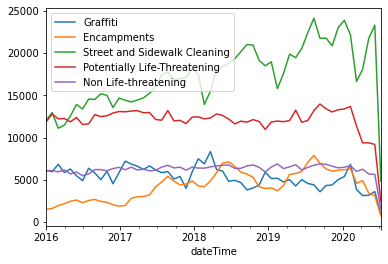

In [52]:
#df[df['category']=='Graffiti'].groupby(pd.Grouper(key="dateTime", freq="7D"))["requestId"].count().plot()

for p in top_categories:
    df[df['category']==p].resample('30d')["requestId"].count().plot(label=p)
    
plt.legend(loc='best')


In [4]:
import datetime 

df = pd.read_parquet('./data/safety-SanFrancisco.parquet') 
df = df.drop(['requestId', 'dataType', 'extendedProperties'], axis=1)
for col in ["dataSubtype", "category", "subcategory"]:
    df[col] = pd.Categorical(df[col])   
df['dateTime'] = pd.to_datetime(df['dateTime'], format='%Y-%m-%d')
df = df[(df['dateTime']>datetime.datetime(2020,1,1,0,0,0)) & (df['dateTime']<datetime.datetime(2020,1,1,10,0,0))]

df = pd.DataFrame.drop_duplicates(df)



print(df['longitude'].size)
longitudes = df['longitude'].values.tolist()
latitudes = df['latitude'].values.tolist()
print(len(longitudes))
markers = []

for lon,lat in zip(longitudes, latitudes):
    markers.append(Marker(location = (lat, lon)))

m = Map(center=(latitudes[0], longitudes[0]), zoom=10, basemap = basemaps.Esri.WorldStreetMap)

marker_cluster = MarkerCluster(
    markers=markers
)

m.add_layer(marker_cluster);
m



504
504


Map(center=[37.75844459479957, -122.46591998484034], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Map(center=[37.75844459479957, -122.46591998484034], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [39]:
from ipyleaflet import basemaps,basemap_to_tiles, Map, WidgetControl
from ipywidgets import Dropdown

m = Map(center=[0, 0], zoom=2)

strata_water = basemap_to_tiles(basemaps.Esri.DeLorme)
m.add_layer(strata_water);

ee_basemaps={}

# Loops through all ipyleaflet basemaps
for item in basemaps.values():
    try:
        name = item['name']
        basemap = 'basemaps.{}'.format(name)
        ee_basemaps[name] = basemap_to_tiles(eval(basemap))
    except:
        for sub_item in item:
            name = item[sub_item]['name']
            basemap = 'basemaps.{}'.format(name)
            basemap = basemap.replace('Mids', 'Modis')
            ee_basemaps[name] = basemap_to_tiles(eval(basemap))

print(len(ee_basemaps))
# Adds a Dropdown widget
dropdown = Dropdown(
    options=list(ee_basemaps.keys()),
    value='Esri.DeLorme',
    description='Basemaps'
)

# Handles Dropdown control event
def on_click(change):
    basemap_name = change['new']
    old_basemap = m.layers[-1]
    m.substitute_layer(old_basemap, ee_basemaps[basemap_name])
    #m = Map(center=(latitudes[0], longitudes[0]), zoom=10, basemap = basemaps.Esri.WorldStreetMap)
    
dropdown.observe(on_click, 'value')

# Adds control to the map
basemap_control = WidgetControl(widget=dropdown, position='topright')
m.add_control(basemap_control)

m

35


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [9]:
df = pd.read_parquet('./data/safety-SanFrancisco.parquet') 
df = df.drop(['dataType', 'extendedProperties'], axis=1)
for col in ["dataSubtype", "category", "subcategory"]:
    df[col] = pd.Categorical(df[col])
df['dateTime'] = pd.to_datetime(df['dateTime'], format='%Y-%m-%d %H:%M:%S')
#df = df[(df['dateTime']>datetime.datetime(2020,1,1,0,0,0)) & (df['dateTime']<datetime.datetime(2020,2,2,10,0,0))]
#df.index=pd.to_datetime(df.index)
df.head()
locator = Nominatim(user_agent="myGeocoder")
coordinates = "37.7828592,-122.4385434"

location = locator.reverse(coordinates)
location.raw


for i in df.index[0:5] : 
    try:
      location = locator.reverse(str(df.loc[i, 'latitude']) + ',' + str(df.loc[i, 'longitude']))  
      print (location.raw['address']['neighbourhood'])
      df['neighbourhood'] = location.raw['address']['neighbourhood']  
    except:    
      #print (location.raw) 
      df['neighbourhood'] = 'n/a'  

#df.groupby(pd.Grouper(key="dateTime", freq="7D"))["requestId"].count()                                 



Western Addition
Chinatown
Marina District
West Portal


In [76]:
import ipyleaflet
import json
import pandas as pd
import os
import requests
from ipywidgets import link, FloatSlider
from branca.colormap import linear

def load_data(url, filename, file_type):
    r = requests.get(url)
    with open(filename, 'w') as f:
        f.write(r.content.decode("utf-8"))
    with open(filename, 'r') as f:
        return file_type(f)

geo_json_data = load_data(
    'https://raw.githubusercontent.com/jupyter-widgets/ipyleaflet/master/examples/us-states.json',
    'us-states.json',
     json.load)

unemployment = load_data(
    'https://raw.githubusercontent.com/jupyter-widgets/ipyleaflet/master/examples/US_Unemployment_Oct2012.csv',
    'US_Unemployment_Oct2012.csv',
     pd.read_csv)

unemployment =  dict(zip(unemployment['State'].tolist(), unemployment['Unemployment'].tolist()))

layer = ipyleaflet.Choropleth(
    geo_data=geo_json_data,
    choro_data=unemployment,
    colormap=linear.YlOrRd_04,
    border_color='black',
    style={'fillOpacity': 0.8, 'dashArray': '5, 5'})

m = ipyleaflet.Map(center = (43,-100), zoom = 4)
m.add_layer(layer)
m

Map(center=[43, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [179]:
locator = Nominatim(user_agent="myGeocoder")
coordinates = "37.7828592,-122.4385434"

location = locator.reverse(coordinates)
location.raw['address']['neighbourhood']


'Western Addition'

In [ ]:
df = pd.read_parquet('./data/safety-SanFrancisco.parquet') 
df = df.drop(['requestId', 'dataType', 'extendedProperties'], axis=1)
for col in ["dataSubtype", "category", "subcategory"]:
    df[col] = pd.Categorical(df[col])
df['dateTime'] = pd.to_datetime(df['dateTime'], format='%Y-%m-%d %H:%M:%S')
df = pd.DataFrame.drop_duplicates(df)

profile = ProfileReport(df, title="Pandas Profiling Report")
#profile 
#profile.to_widgets()
#profile.to_notebook_iframe()
profile.to_file("sf.html")
df.to_parquet("sf-c.parquet", compression="snappy")

df = pd.read_parquet('./data/safety-Seattle.parquet') 
df = df.drop(['requestId', 'dataType', 'extendedProperties'], axis=1)
for col in ["dataSubtype", "category", "subcategory"]:
    df[col] = pd.Categorical(df[col])
df['dateTime'] = pd.to_datetime(df['dateTime'], format='%Y-%m-%d %H:%M:%S')
df = pd.DataFrame.drop_duplicates(df)

profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_file("se.html")
df.to_parquet("se-c.parquet", compression="snappy")

df = pd.read_parquet('./data/safety-Nyc.parquet') 
df = df.drop(['requestId', 'dataType', 'extendedProperties'], axis=1)
for col in ["dataSubtype", "category", "subcategory"]:
    df[col] = pd.Categorical(df[col])
df['dateTime'] = pd.to_datetime(df['dateTime'], format='%Y-%m-%d %H:%M:%S')
df = pd.DataFrame.drop_duplicates(df)

profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_file("ny.html")
df.to_parquet("ny.parquet", compression="snappy")